# Let's Import the Libraries to be used:

## 1. Let's download the libraries we'll be using

In [ ]:
%pip install --use-deprecated=legacy-resolver pycaret[full]


## 2. Let's import the libraries

In [1]:
import numpy as np
import  pandas as pd
import  seaborn as sns
import  scipy.stats as stats
import  matplotlib.pyplot as plt

from pycaret.regression import *

# To recap...


In the last notebook, we changed the structure and form of the explanatory variables to make machine learning easier, going through the whole feature engineering and feature selection pipeline.

In this notebook, we will test various machine learning models and check their performance on various metrics, choosing the one that performs best.

But first, let's re-access the data we had processed:

To-do: we need to iterate through each feature and each dataset

In [2]:
target_features=["yield_strength",
"ultimate_tensile_strength",]

Since both targets are simillar, we will choose only one of them, without lost of information

In [3]:
target = target_features[0]

In [4]:
def load_dataset(dataset):
    X_train = pd.read_csv(f'processed_data/{dataset}/processed_train_{dataset}.csv')

    X_train[target] = pd.read_csv("data/train.csv")[target]

    X_valid = pd.read_csv(f'processed_data/{dataset}/processed_validation_{dataset}.csv')

    X_valid[target] = pd.read_csv("data/validation.csv")[target]

    X_train = X_train.append(X_valid)
    X_train = X_train.reset_index(drop=True)

    X_test = pd.read_csv(f'processed_data/{dataset}/processed_test_{dataset}.csv')

    X_test[target] = pd.read_csv("data/test.csv")[target]

    X_train = X_train.dropna(subset=[target])
    X_test = X_test.dropna(subset=[target])

    return X_train, X_test

In [5]:
X_train, X_test = load_dataset("custom")

# Choosing the Best Model

To check a wide range of models, we're going to use Pycaret, an AutoML library.
With the data processed, we can start testing possible model candidates.

In [10]:
def create_session(X_train, target):
    exp_clf101 = setup(data = X_train,
                    target = target,
                    normalize = True,
                    transformation = True,
                    session_id=123,
                    feature_selection=True,
                    index=False,
                    remove_multicollinearity = True,
                    multicollinearity_threshold = 0.95,
                    n_features_to_select=0.6)
    return exp_clf101

In [11]:
exp_clf101 = create_session(X_train, target)

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 43)"
4,Transformed data shape,"(657, 26)"
5,Transformed train set shape,"(459, 26)"
6,Transformed test set shape,"(198, 26)"
7,Numeric features,42
8,Preprocess,True
9,Imputation type,simple


## Comparing Models


To compare the models, we will first use the R2 metric. A Kfold will be used for cross validation with k=10. Let's now test several different models and see which one works best on the desired dataset:

In [12]:
def choose_models(selected_models=4):
    best_models = compare_models(sort = 'r2',n_select = selected_models)
    return best_models

In [45]:
best_models = choose_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,29.8758,1873.2061,42.5447,0.7814,0.0813,0.0590,0.2250
lightgbm,Light Gradient Boosting Machine,30.9428,1884.5791,42.7817,0.7731,0.0816,0.0610,0.1930
gbr,Gradient Boosting Regressor,34.6721,2255.2397,47.1476,0.7302,0.0894,0.0680,0.2300
xgboost,Extreme Gradient Boosting,34.5462,2293.5133,47.3383,0.7202,0.0901,0.0680,0.2120
rf,Random Forest Regressor,36.1403,2432.0296,48.9437,0.7065,0.0943,0.0718,0.3060
ada,AdaBoost Regressor,42.3038,3073.9421,55.0724,0.6405,0.1076,0.0856,0.1870
knn,K Neighbors Regressor,42.5694,3519.1428,58.6945,0.5822,0.1125,0.0844,0.1650
lasso,Lasso Regression,47.7167,4303.2705,64.9838,0.5111,0.1201,0.0928,0.1790
llar,Lasso Least Angle Regression,47.7169,4303.3664,64.9845,0.5111,0.1201,0.0928,0.1710
br,Bayesian Ridge,47.9309,4300.6934,65.0083,0.5105,0.1201,0.0932,0.1380


In [46]:
best_models[0].feature_names_in_

array(['carbon_concentration_per_weight',
       'silicon_concentration_per_weight',
       'manganese_concentration_per_weight',
       'sulphur_concentration_per_weight',
       'phosphorus_concentration_per_weight',
       'hromium_concentration_per_weight',
       'olybdenum_concentration_per_weight',
       'anadium_concentration_per_weight',
       'oxygen_concentration_per_parts_per_million_by_weight',
       'titanium_concentration_per_parts_per_million_by_weight',
       'nitrogen_concentration_per_parts_per_million_by_weight',
       'heat_input', 'post_weld_heat_treatment_temperature', 'elongation',
       'reduction_of_area', 'UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_4',
       'UMAP_5', 'UMAP_6', 'UMAP_7', 'UMAP_8', 'UMAP_9', 'UMAP_10'],
      dtype=object)

In [13]:
def blend_best_models(best_models):
    blend_model = blend_models(best_models,fold=10)
    final_blend_model = finalize_model(blend_model)
    return final_blend_model

In [48]:
final_blend_model = blend_best_models(best_models)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:35:02
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.0270,1860.8223,43.1372,0.7941,0.0732,0.0565
1,31.4558,1769.6761,42.0675,0.8226,0.0769,0.0608
2,30.5873,1790.0490,42.3090,0.8813,0.0799,0.0588
3,25.5319,1228.6958,35.0528,0.8027,0.0717,0.0529
4,24.7700,1131.4948,33.6377,0.8671,0.0703,0.0529
5,28.9373,1537.6871,39.2134,0.8382,0.0766,0.0581
6,39.4508,3482.9402,59.0164,0.6218,0.1190,0.0812
7,32.0650,1940.0551,44.0461,0.6475,0.0816,0.0627
8,30.0379,1645.8896,40.5696,0.7907,0.0750,0.0603


# Evaluating

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from typing import List

def plot_results(y_true: List[float], y_pred: List[float]) -> None:
    """
    Plot both the standardized residuals plot and the predicted vs true values plot side by side,
    with a common title that includes the R2 score.

    Args:
        y_true: List of true values.
        y_pred: List of predicted values.

    Returns:
        None

    Raises:
        ValueError: If y_true and y_pred have different lengths.
    """

    # Check if lengths are the same
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")

    # Calculate the residuals
    residuals = np.array(y_true) - np.array(y_pred)

    # Standardize the residuals
    std_residuals = residuals / np.std(residuals)

    # Calculate the R2 score
    r2 = r2_score(y_true, y_pred)

    # Create the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Common title with R2 score
    fig.suptitle(fr"Evaluation of Weld quality prediction - = {r2:.2f}", fontsize=18)

    # Plot for standardized residuals
    axes[0].scatter(y_pred, std_residuals, c='blue')
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel("Predicted Values", fontsize=14)
    axes[0].set_ylabel("Standardized Residuals", fontsize=14)
    axes[0].set_title("Standardized Residuals Plot", fontsize=16)

    # Plot for y_true vs y_pred
    axes[1].scatter(y_pred, y_true, c='blue', label='Data')
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='x=y')
    axes[1].set_xlabel("Predicted Values", fontsize=14)
    axes[1].set_ylabel("True Values", fontsize=14)
    axes[1].set_title("Predicted vs True Values", fontsize=16)
    axes[1].legend(fontsize=12)

    # Show the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [15]:
def evaluate_model(model, X_test, plot=True):
    weld_pred = predict_model(model,data=X_test)
    y_pred = weld_pred['prediction_label']
    y_true = weld_pred[target]
    if plot:
        plot_results(y_true,y_pred)

# Best Datasets

In [20]:
datasets = ["custom", "constant", "multiple", "knn", "mean"]

def evaluate_dataset(dataset):
    X_train, X_test = load_dataset(dataset)
    exp_clf101 = create_session(X_train, target)
    best_models = choose_models()
    final_model = blend_best_models(best_models)
    evaluate_model(final_model, X_test, plot=True)   

custom
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 42
[LightGBM] [Info] Start training from score 507.419172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 46)"
4,Transformed data shape,"(657, 28)"
5,Transformed train set shape,"(459, 28)"
6,Transformed test set shape,"(198, 28)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,30.0840,1914.3667,42.9063,0.7772,0.0829,0.0598,0.3660
lightgbm,Light Gradient Boosting Machine,31.7286,1982.0324,44.0679,0.7688,0.0848,0.0623,0.4530
gbr,Gradient Boosting Regressor,33.1397,2221.6061,46.5665,0.7390,0.0899,0.0657,0.4070
rf,Random Forest Regressor,34.6138,2339.5654,48.0646,0.7262,0.0933,0.0692,0.5500
xgboost,Extreme Gradient Boosting,33.3783,2370.8933,47.8321,0.7250,0.0914,0.0660,0.5010
ada,AdaBoost Regressor,40.6116,2900.7858,53.4175,0.6607,0.1049,0.0821,0.3030
knn,K Neighbors Regressor,40.8524,3389.9998,57.6876,0.5877,0.1120,0.0817,0.2620
br,Bayesian Ridge,46.0989,3797.2619,61.0662,0.5542,0.1155,0.0907,0.2880
llar,Lasso Least Angle Regression,46.0879,3841.9919,61.3980,0.5508,0.1155,0.0904,0.3190
lasso,Lasso Regression,46.0877,3841.9713,61.3979,0.5508,0.1155,0.0904,0.2740


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.5140,2036.6705,45.1295,0.7746,0.0795,0.0586
1,33.4370,2157.2342,46.4460,0.7837,0.0838,0.0643
2,32.3609,2535.7132,50.3559,0.8319,0.1004,0.0655
3,27.6061,1335.3371,36.5423,0.7855,0.0716,0.0557
4,25.2406,1281.9325,35.8041,0.8494,0.0755,0.0546
5,29.1550,1472.3635,38.3714,0.8451,0.0779,0.0595
6,36.9758,3267.7330,57.1641,0.6452,0.1155,0.0764
7,25.4428,1473.0138,38.3799,0.7324,0.0713,0.0496
8,30.3528,1404.2223,37.4730,0.8215,0.0739,0.0617


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,24.6824,1634.2963,40.4264,0.8211,0.0686,0.0473


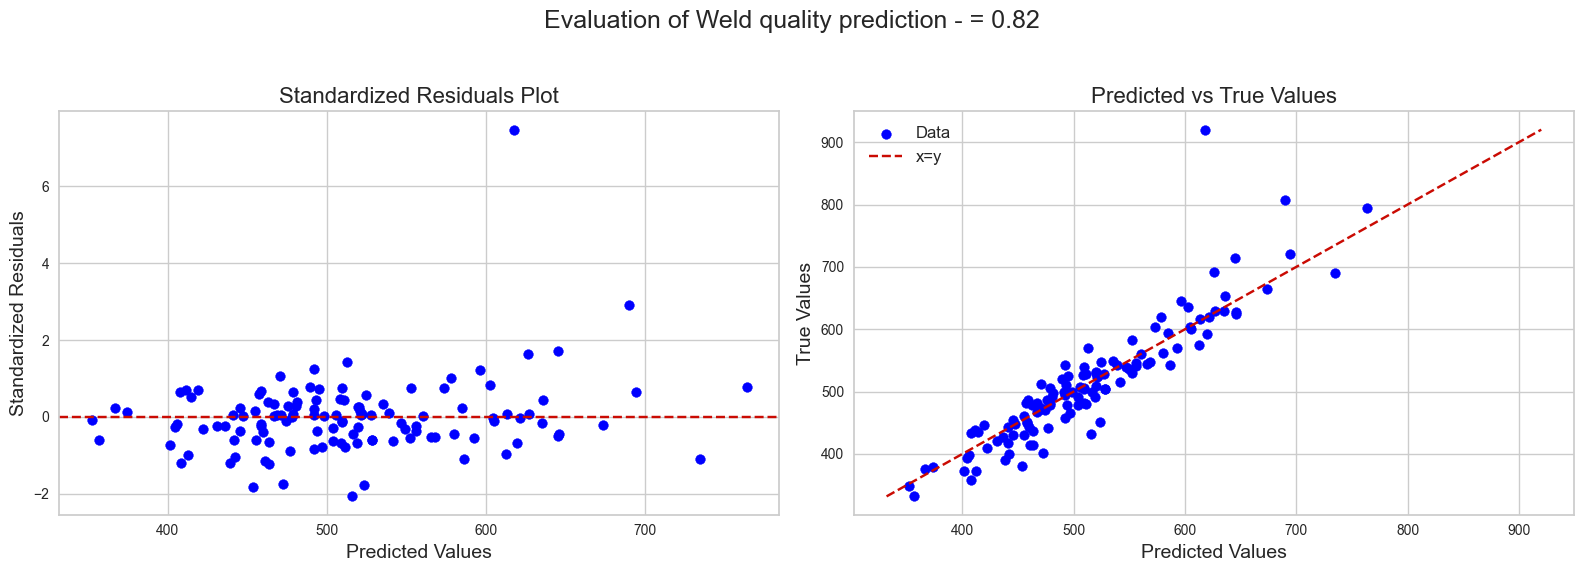

constant
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 43
[LightGBM] [Info] Start training from score 507.419172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 46)"
4,Transformed data shape,"(657, 28)"
5,Transformed train set shape,"(459, 28)"
6,Transformed test set shape,"(198, 28)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,30.5575,1857.7122,42.4527,0.7754,0.0811,0.0599,0.3170
et,Extra Trees Regressor,30.3587,1980.2107,43.3358,0.7640,0.0829,0.0599,0.4090
xgboost,Extreme Gradient Boosting,32.7200,2066.8844,44.5802,0.7453,0.0857,0.0648,0.4110
gbr,Gradient Boosting Regressor,32.9888,2143.7142,45.6485,0.7402,0.0879,0.0653,0.4000
rf,Random Forest Regressor,34.2397,2301.2985,47.2538,0.7220,0.0917,0.0684,0.5780
ada,AdaBoost Regressor,41.5607,3025.6543,54.7601,0.6402,0.1065,0.0836,0.3060
knn,K Neighbors Regressor,43.0783,3436.5941,58.1252,0.5905,0.1131,0.0856,0.2250
dt,Decision Tree Regressor,44.1623,3964.4967,62.1379,0.5046,0.1214,0.0883,0.2500
llar,Lasso Least Angle Regression,50.0381,4249.6696,64.8650,0.4978,0.1236,0.0990,0.2300
lasso,Lasso Regression,50.0375,4249.6052,64.8645,0.4978,0.1236,0.0990,0.2150


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,26.9380,1429.5404,37.8093,0.8418,0.0657,0.0480
1,31.2002,1834.0449,42.8257,0.8161,0.0765,0.0596
2,30.4539,1635.3381,40.4393,0.8916,0.0798,0.0600
3,24.9107,1273.4448,35.6854,0.7955,0.0708,0.0503
4,24.8856,1170.5873,34.2138,0.8625,0.0715,0.0531
5,25.9743,1063.3621,32.6092,0.8881,0.0650,0.0526
6,39.2637,3626.9438,60.2241,0.6062,0.1206,0.0808
7,28.0051,2013.9777,44.8774,0.6341,0.0826,0.0557
8,29.3462,1374.3079,37.0717,0.8253,0.0729,0.0591


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,25.2897,1686.2789,41.0643,0.8154,0.0685,0.0477


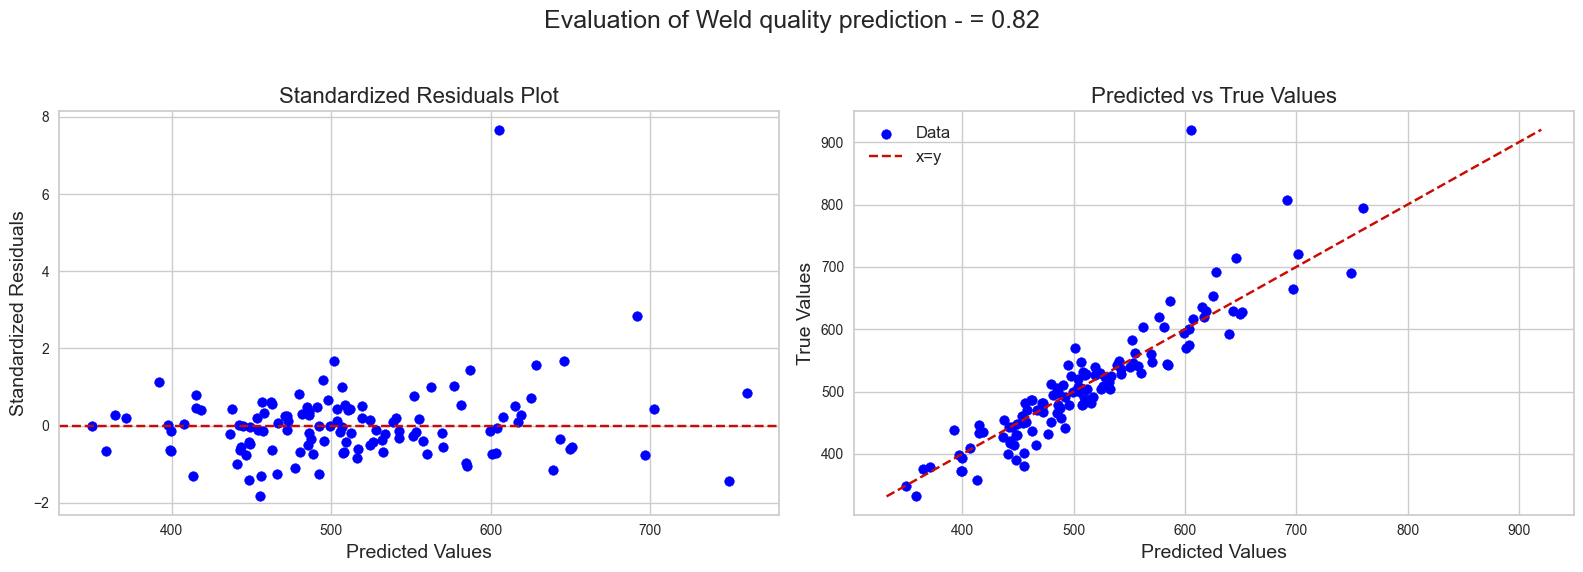

multiple
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4380
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 45
[LightGBM] [Info] Start training from score 507.419172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 46)"
4,Transformed data shape,"(657, 28)"
5,Transformed train set shape,"(459, 28)"
6,Transformed test set shape,"(198, 28)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,32.0402,2081.7119,45.1579,0.7574,0.0858,0.0629,0.3840
lightgbm,Light Gradient Boosting Machine,32.9465,2136.9304,45.7356,0.7516,0.0871,0.0648,0.3340
gbr,Gradient Boosting Regressor,34.5296,2291.3654,47.4013,0.7304,0.0906,0.0680,0.4390
xgboost,Extreme Gradient Boosting,35.4058,2575.0343,50.3357,0.6984,0.0963,0.0697,0.4520
rf,Random Forest Regressor,38.0987,2848.2320,52.8568,0.6714,0.1003,0.0750,0.6170
knn,K Neighbors Regressor,41.0610,3236.0190,56.4117,0.6191,0.1080,0.0809,0.2710
ada,AdaBoost Regressor,44.1361,3415.0291,58.2995,0.5963,0.1125,0.0884,0.3260
br,Bayesian Ridge,46.0996,3866.9417,61.8415,0.5494,0.1161,0.0902,0.2520
llar,Lasso Least Angle Regression,46.2605,3926.1512,62.2377,0.5443,0.1169,0.0906,0.2400
lasso,Lasso Regression,46.2610,3926.1605,62.2376,0.5443,0.1169,0.0906,0.2350


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,29.7568,1638.9504,40.4840,0.8186,0.0717,0.0540
1,34.6949,2408.0162,49.0715,0.7586,0.0872,0.0660
2,37.1415,2932.9770,54.1570,0.8056,0.0991,0.0703
3,26.6247,1420.2462,37.6862,0.7719,0.0751,0.0543
4,28.2203,1580.2279,39.7521,0.8144,0.0814,0.0598
5,30.1507,1651.4715,40.6383,0.8262,0.0808,0.0613
6,37.4853,3124.8658,55.9005,0.6607,0.1135,0.0770
7,29.6697,1802.0439,42.4505,0.6726,0.0792,0.0586
8,30.3114,1430.0500,37.8160,0.8182,0.0755,0.0617


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,26.5019,1901.2092,43.6029,0.7919,0.0759,0.0507


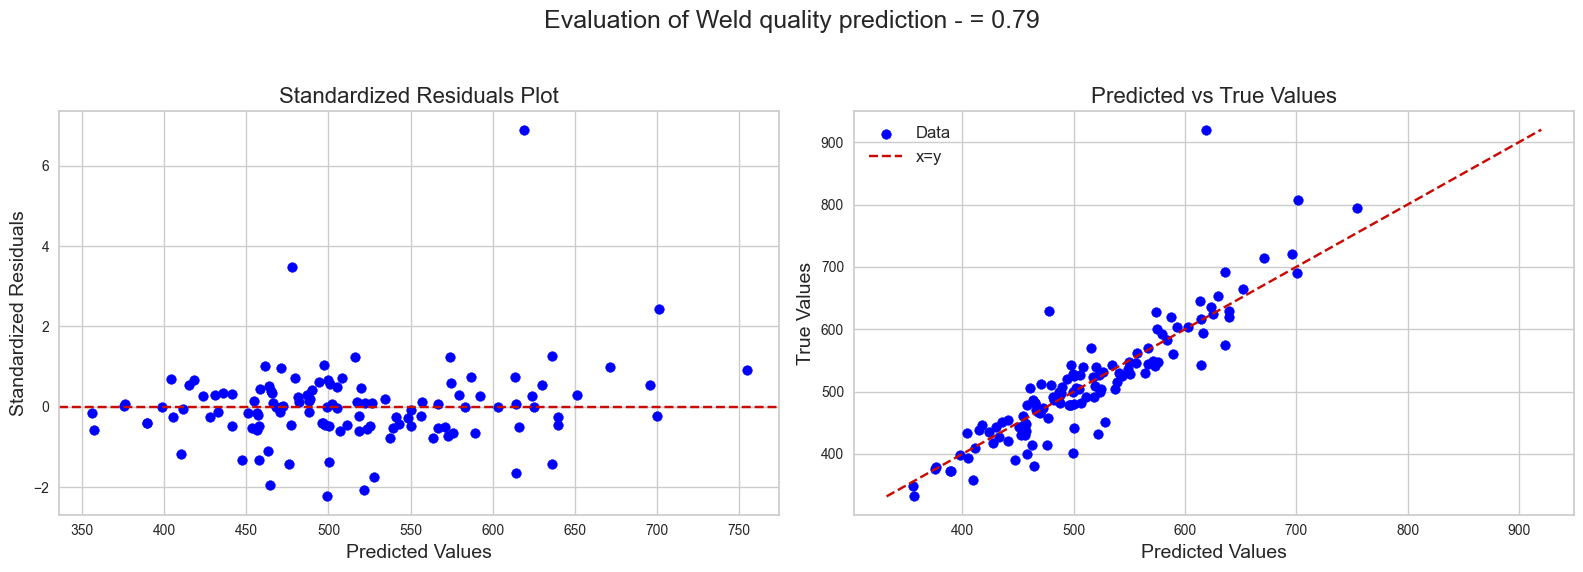

knn
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 45
[LightGBM] [Info] Start training from score 507.419172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 46)"
4,Transformed data shape,"(657, 28)"
5,Transformed train set shape,"(459, 28)"
6,Transformed test set shape,"(198, 28)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,30.8384,1982.0611,43.8915,0.7647,0.0840,0.0607,0.3650
gbr,Gradient Boosting Regressor,32.8809,2115.7644,45.6286,0.7431,0.0876,0.0650,0.3920
lightgbm,Light Gradient Boosting Machine,31.8160,2107.4253,45.3023,0.7422,0.0861,0.0624,0.3250
rf,Random Forest Regressor,36.5814,2646.3446,50.8706,0.6766,0.0973,0.0724,0.5660
xgboost,Extreme Gradient Boosting,35.6579,2701.3149,51.5232,0.6659,0.0968,0.0701,0.3910
ada,AdaBoost Regressor,42.6238,3274.4812,56.6961,0.6152,0.1107,0.0860,0.2940
knn,K Neighbors Regressor,41.9362,3355.5353,57.3822,0.6039,0.1088,0.0822,0.2130
br,Bayesian Ridge,44.5629,3511.2906,58.8526,0.5868,0.1107,0.0871,0.2170
llar,Lasso Least Angle Regression,44.3891,3537.4802,59.0212,0.5855,0.1105,0.0864,0.2350
lasso,Lasso Regression,44.3893,3537.4536,59.0209,0.5855,0.1105,0.0864,0.2310


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33.0757,2243.4963,47.3656,0.7518,0.0815,0.0584
1,33.9234,2362.8894,48.6096,0.7631,0.0858,0.0644
2,28.6769,1555.5817,39.4409,0.8969,0.0796,0.0570
3,29.8833,1802.5374,42.4563,0.7105,0.0832,0.0612
4,26.7885,1458.7608,38.1937,0.8287,0.0790,0.0577
5,27.4748,1329.9571,36.4686,0.8601,0.0724,0.0556
6,33.6543,2856.4990,53.4462,0.6898,0.1106,0.0711
7,28.9119,1807.5276,42.5150,0.6716,0.0784,0.0558
8,32.3040,1495.9442,38.6774,0.8098,0.0755,0.0654


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,24.5514,1738.0205,41.6896,0.8097,0.0697,0.0464


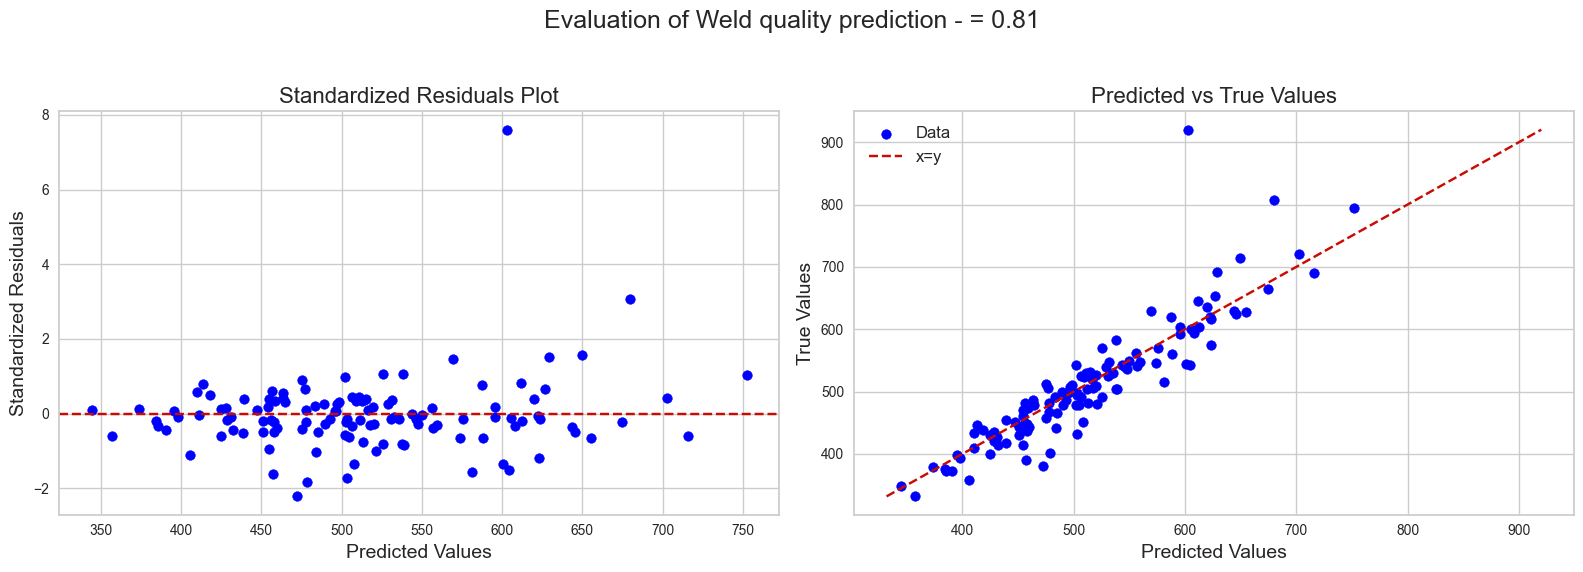

mean
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 44
[LightGBM] [Info] Start training from score 507.419172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 46)"
4,Transformed data shape,"(657, 28)"
5,Transformed train set shape,"(459, 28)"
6,Transformed test set shape,"(198, 28)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,29.5326,1803.4259,41.7116,0.7855,0.0807,0.0586,0.3930
lightgbm,Light Gradient Boosting Machine,32.4673,2086.1368,44.9623,0.7504,0.0865,0.0638,0.3600
gbr,Gradient Boosting Regressor,33.1560,2102.4422,45.3084,0.7455,0.0878,0.0660,0.4240
xgboost,Extreme Gradient Boosting,33.4194,2212.6935,46.5096,0.7315,0.0894,0.0660,0.3890
rf,Random Forest Regressor,35.8240,2483.8822,49.2745,0.7012,0.0953,0.0713,0.5710
ada,AdaBoost Regressor,40.7233,2904.8458,53.6067,0.6598,0.1043,0.0820,0.2860
knn,K Neighbors Regressor,39.7174,3006.8992,54.1353,0.6373,0.1058,0.0794,0.2070
lasso,Lasso Regression,44.8370,3593.8254,59.6107,0.5792,0.1113,0.0871,0.2270
llar,Lasso Least Angle Regression,44.8363,3593.7302,59.6099,0.5792,0.1113,0.0871,0.2430
br,Bayesian Ridge,45.0720,3588.7904,59.6220,0.5762,0.1116,0.0877,0.2430


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,28.0566,1411.9513,37.5759,0.8438,0.0675,0.0516
1,31.3040,1963.0728,44.3066,0.8032,0.0791,0.0596
2,29.4148,1633.7597,40.4198,0.8917,0.0770,0.0567
3,27.4152,1369.9657,37.0130,0.7800,0.0734,0.0554
4,27.5845,1401.2753,37.4336,0.8354,0.0782,0.0591
5,26.9710,1269.5092,35.6302,0.8664,0.0719,0.0551
6,38.6282,3584.7890,59.8731,0.6107,0.1217,0.0795
7,29.7730,1717.0363,41.4371,0.6880,0.0777,0.0588
8,30.1349,1371.5218,37.0341,0.8256,0.0746,0.0619


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,24.0946,1589.0132,39.8624,0.8261,0.0683,0.0465


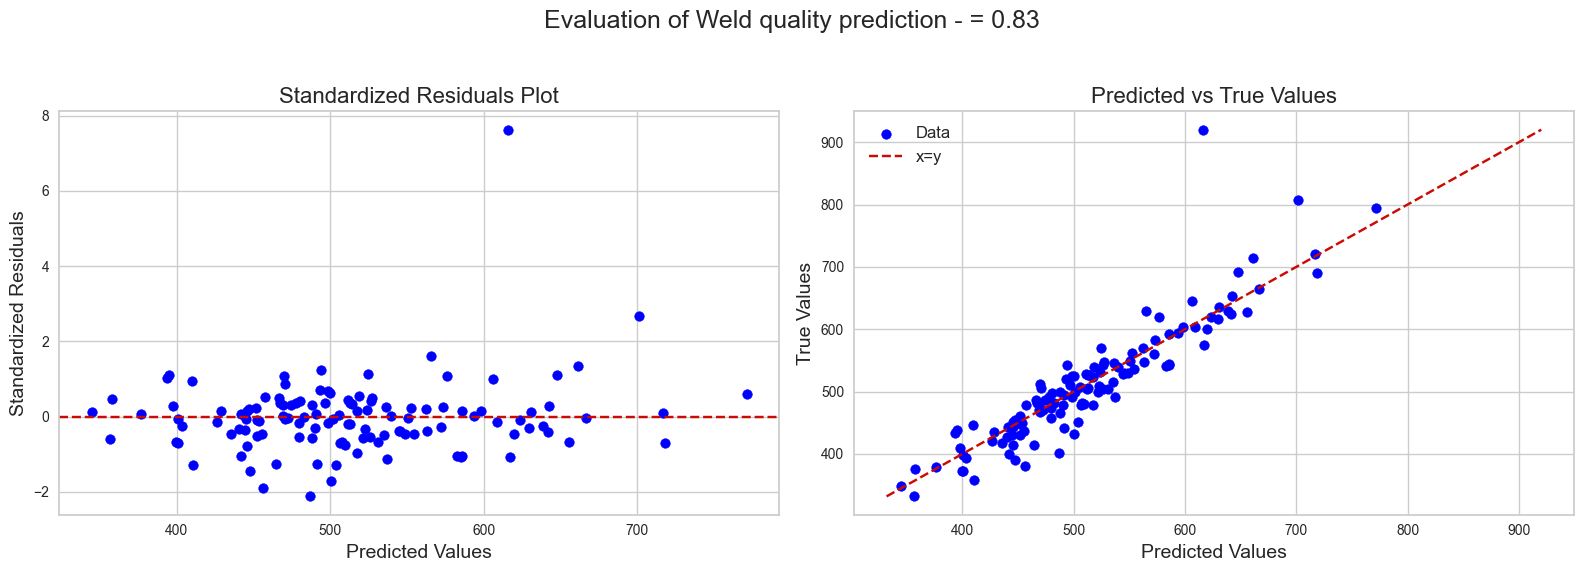

In [21]:
for dataset in datasets:
    print(dataset)
    evaluate_dataset(dataset)

It's possible to see that our custom dataset and the one with KNN imputation had the best results. Extra Trees regression looks like it is the most suitable model